In [1]:
import numpy as np
from tqdm import tqdm
import time
import math
import gc
import torch
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast, DataCollatorForLanguageModeling

In [2]:
from importlib import reload
import stationary_reversal as sr
reload(sr)

<module 'stationary_reversal' from 'c:\\Users\\abhay\\Documents\\research\\reverse-dynamics-nlp\\reverse-llm-benchmarking\\stationary_reversal.py'>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTNeoXForCausalLM.from_pretrained(
    "EleutherAI/pythia-160m-deduped",
    revision="step3000",
    device_map="auto",
)
tokenizer = GPTNeoXTokenizerFast.from_pretrained("EleutherAI/gpt-neox-20b")


In [4]:
prefix_length = 2
suffix = " Obama"
tokenized_suffix= tokenizer.encode(suffix, return_tensors="pt").to(device)
# tokenized_suffix = tokenized_suffix.unsqueeze(0)
suffix_length = len(tokenized_suffix[0])
empirical_dist = torch.load("..\data\pythia-160m-deduped-v0_stationary_dist.pt").cuda()

vocab_size = empirical_dist.shape[0]

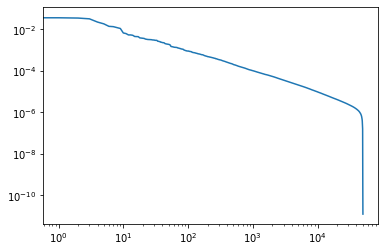

In [5]:
import matplotlib.pyplot as plt
plt.loglog(empirical_dist.sort(descending=True).values.cpu().detach())

In [6]:
uniform_dist = torch.ones_like(empirical_dist) / empirical_dist.shape[0]
empirical_dist = empirical_dist * 0.7 + uniform_dist * 0.3

In [7]:
from reverse_sampling import sample_reverse_dynamics

output1, logits1 = sample_reverse_dynamics(
    model,
    empirical_dist,
    prefix_length,
    tokenized_suffix,
    temperature=0.7,
    vocab_batch_size=512
)

100%|██████████| 197/197 [00:20<00:00,  9.68it/s]


In [8]:
tokenizer.decode(output1[0])

' in the Obama'

In [9]:
logits2 = sr.stationary_reverse_full_dist_suffix_calculation(model, empirical_dist, output1)

i= 0


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


i= 0


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


In [18]:
logits1.log_softmax(dim=-1)

tensor([[-14.3580, -15.5943, -11.6032,  ..., -15.6097, -16.5010, -12.2551],
        [-13.5377, -15.0662,  -8.3655,  ..., -14.6411, -13.6813, -13.2714]],
       device='cuda:0')

In [22]:
torch.abs(logits2 - logits1.log_softmax(dim=-1)).max()

tensor(2.1935e-05, device='cuda:0')

In [ ]:
1/0

In [10]:
model.eval()
vocab_size = empirical_dist.shape[0]
posterior = torch.zeros(vocab_size)
total_batches = math.ceil(vocab_size / 1024)

In [11]:
total_batches

50

In [12]:
from tqdm import tqdm
from stationary_reversal import get_logprob

outs = []

for batch_num in tqdm(range(total_batches)):
    start_idx = batch_num * 1024
    end_idx = start_idx + 1024

    batch_indices = (
        torch.arange(start_idx, min(end_idx, vocab_size) ).clamp(0, vocab_size - 1).to(device)
    )
    v_sentences = torch.cat(
        (batch_indices.unsqueeze(1), tokenized_suffix.repeat(batch_indices.size(0), 1)),
        dim=-1,
    )
    
    probs = get_logprob(v_sentences, model, empirical_dist.cuda())
    outs.append(probs)

100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


In [13]:
def sample_with_temp(distribution, temperature):
    if temperature == 0:
        p = distribution.argmax()
    else:
        p = torch.distributions.Categorical(
            logits = distribution / temperature
        ).sample()
    return p

sample_with_temp(torch.cat(outs), 0)

tensor(13, device='cuda:0')

In [14]:
tokenizer.decode(sample_with_temp(torch.cat(outs), 0.5).unsqueeze(0)) 

','

In [15]:
outs[-1]

tensor([-26.7630, -22.0466, -21.8735, -26.0990, -23.2271, -22.4885, -22.6107,
        -25.2680, -23.6408, -26.6936, -23.3390, -24.8539, -24.7472, -24.8062,
        -23.5538, -24.2841, -26.1625, -24.7110, -22.3090, -26.2174, -22.5029,
        -21.8936, -23.6981, -23.3042, -21.7442, -24.8633, -24.3059, -27.3021,
        -24.2578, -22.4145, -25.6852, -20.4311, -23.4249, -24.3987, -23.5652,
        -25.0529, -23.8547, -26.3205, -23.7349, -25.1287, -24.8162, -23.9619,
        -22.6867, -26.0871, -23.5201, -24.0985, -24.0007, -22.9320, -24.3523,
        -23.0888, -26.5006, -22.4001, -25.2355, -23.2697, -23.2889, -22.4503,
        -24.5216, -24.5972, -23.9491, -21.4096, -21.8825, -25.3212, -21.8542,
        -21.9083, -22.9842, -23.7358, -22.8864, -25.3956, -27.7277, -22.5848,
        -23.4009, -25.1718, -24.1344, -26.8903, -25.7522, -25.4923, -23.8582,
        -24.5713, -23.2341, -24.2754, -22.8941, -22.9564, -24.1093, -23.1010,
        -22.8915, -22.5268, -23.3597, -24.6790, -23.3667, -23.37

In [16]:
vocab_size /1024

49.125